In [214]:
import numpy as np
from gensim.models import Word2Vec
import snap
import operator
import snap
from scipy.stats import binom
import matplotlib.pyplot as plt

In [215]:
def getNumAcquired(sim_rankings, acquired_companies_in_graph_by_id, k):
    top_rankings = sim_rankings[:k]
    result = 0
    
    for tup in top_rankings:
        company_id = int(tup[0])
        if company_id in acquired_companies_in_graph_by_id: result += 1
    
    return result

In [248]:
def getCompaniesToNumAcquired(k, node_to_sorted_L2_similarities, acquired_companies_in_graph_by_id, companies):
    result = {}

    for company_id in companies:
        sim_rankings = node_to_sorted_L2_similarities[str(company_id)]
        result[company_id] = getNumAcquired(sim_rankings, acquired_companies_in_graph_by_id, k)
                                     
    return result

In [249]:
def getNullProbs(companies_to_num_acquired, n, p):
    result = {}
    
    for key in companies_to_num_acquired:
        result[key] = binom.pmf(companies_to_num_acquired[key], n, p)
        
    return result

In [218]:
# Returns a list sorted from the node with the least l2 distance to 
# reference node to the node with the greatest l2 distance
def calculateSortedL2Similarity(reference_node, model):
    reference_embeddings = model[reference_node]
    l2_similarities = {}

    for key in model.vocab:
        if key != reference_node:
            curr_l2 = np.linalg.norm(reference_embeddings - model[key])
            l2_similarities[key] = curr_l2

    sorted_l2_similarities = sorted(l2_similarities.items(), key=operator.itemgetter(1))
    return sorted_l2_similarities

In [219]:
def createSortedSimilaritesMap(model):
    result = {}
    for key in model.vocab:
        result[key] = calculateSortedL2Similarity(key, model)
    return result

In [9]:
# Load the embeddings from memory
BFS_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/company_embeddings_p1_q100.emd")
neutral_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/company_embeddings_p1_q1.emd")
DFS_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/company_embeddings_p1_q0_01.emd")

In [10]:
BFS_nodeToSortedL2Similarities = createSortedSimilaritesMap(BFS_model)
print "Completed BFS model"
neutral_nodeToSortedL2Similarities = createSortedSimilaritesMap(neutral_model)
print "Completed neutral model"
DFS_nodeToSortedL2Similarities = createSortedSimilaritesMap(DFS_model)
print "Completed DFS model"

Completed BFS model
Completed neutral model
Completed DFS model


In [15]:
'''
DO NOT RUN THIS AGAIN!

np.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q100", BFS_nodeToSortedL2Similarities)
np.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q1", neutral_nodeToSortedL2Similarities)
np.save("../node2vec_embeddings/nodeToSortedL2Similarities_p1_q0_01", DFS_nodeToSortedL2Similarities)
'''

In [35]:
# These are all of the acquired companies we know about
acquired_companies = set(np.load("../acquired_companies.npy"))

4563


In [201]:
# Now we find the overlap between companies in our graph and the set of acquired companies
node_id_to_value = np.load("../../graphs/investors_to_companies_directed/node_id_to_value.npy").item()
FIn = snap.TFIn("../../graphs/investors_to_companies_directed/investors_to_companies_directed_folded_reverse_order.graph")
G = snap.TUNGraph.Load(FIn)

companies_in_graph = set()
for EI in G.Edges(): 
    curr_src_id = EI.GetSrcNId()
    curr_dst_id = EI.GetDstNId()
    companies_in_graph.add(node_id_to_value[curr_src_id])
    companies_in_graph.add(node_id_to_value[curr_dst_id])
    
# These are the acquired companies in our folded graph
acquired_companies_in_graph = companies_in_graph.intersection(acquired_companies)

acquired_companies_in_graph_by_id = []
value_to_node_id = {v: k for k, v in node_id_to_value.iteritems()}
for company in acquired_companies_in_graph:
    acquired_companies_in_graph_by_id.append(value_to_node_id[company])
    
    
not_acquired_companies_in_graph = companies_in_graph.difference(acquired_companies)
not_acquired_companies_in_graph_by_id = []
for company in not_acquired_companies_in_graph:
    not_acquired_companies_in_graph_by_id.append(value_to_node_id[company])

In [254]:
# Need to look at companies that are NOT acquired too

k = 100
acquired_to_num_acquired_BFS = getCompaniesToNumAcquired(k, BFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, acquired_companies_in_graph_by_id)
acquired_to_num_acquired_neutral = getCompaniesToNumAcquired(k, neutral_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, acquired_companies_in_graph_by_id)
acquired_to_num_acquired_DFS = getCompaniesToNumAcquired(k, DFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, acquired_companies_in_graph_by_id)
# Make a plot for each of BFS, neutral, and DFS
# x axis will be node id
# y axis will be probability under null (binomial) model
p = float(len(acquired_companies_in_graph_by_id)) / len(companies_in_graph)
BFS_null_model_probabilities = getNullProbs(acquired_to_num_acquired_BFS, k, p)
neutral_null_model_probabilities = getNullProbs(acquired_to_num_acquired_neutral, k, p)
DFS_null_model_probabilities = getNullProbs(acquired_to_num_acquired_DFS, k, p)


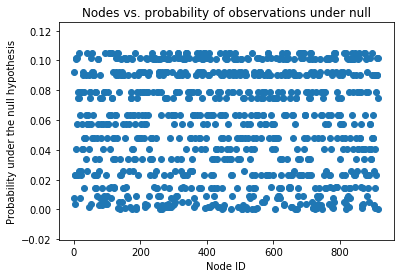

In [255]:
X = range(len(acquired_companies_in_graph_by_id))
x_vals = sorted(acquired_companies_in_graph_by_id)

y_vals = []
for val in x_vals:
    y_vals.append(neutral_null_model_probabilities[val])

plt.xlabel("Node ID")
plt.ylabel("Probability under the null hypothesis")
plt.title("Nodes vs. probability of observations under null")
plt.scatter(X, y_vals)
plt.show()

In [258]:
# Need to look at companies that are NOT acquired too

k = 100
not_acquired_to_num_acquired_BFS = getCompaniesToNumAcquired(k, BFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, not_acquired_companies_in_graph_by_id)
not_acquired_to_num_acquired_neutral = getCompaniesToNumAcquired(k, neutral_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, not_acquired_companies_in_graph_by_id)
not_acquired_to_num_acquired_DFS = getCompaniesToNumAcquired(k, DFS_nodeToSortedL2Similarities, acquired_companies_in_graph_by_id, not_acquired_companies_in_graph_by_id)
# Make a plot for each of BFS, neutral, and DFS
# x axis will be node id
# y axis will be probability under null (binomial) model
p = float(len(acquired_companies_in_graph_by_id)) / len(companies_in_graph)
BFS_null_model_probabilities = getNullProbs(not_acquired_to_num_acquired_BFS, k, p)
neutral_null_model_probabilities = getNullProbs(not_acquired_to_num_acquired_neutral, k, p)
DFS_null_model_probabilities = getNullProbs(not_acquired_to_num_acquired_DFS, k, p)


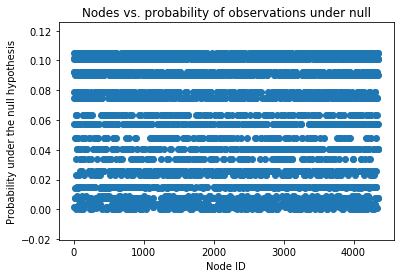

In [259]:
X = range(len(not_acquired_companies_in_graph_by_id))
x_vals = sorted(not_acquired_companies_in_graph_by_id)

y_vals = []
for val in x_vals:
    y_vals.append(BFS_null_model_probabilities[val])

plt.xlabel("Node ID")
plt.ylabel("Probability under the null hypothesis")
plt.title("Nodes vs. probability of observations under null")
plt.scatter(X, y_vals)
plt.show()